<a href="https://colab.research.google.com/github/siti-alawiyah/ibresultprediction/blob/main/Linear_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports
# ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNetCV
from sklearn import metrics

import statsmodels.api as sm
from scipy import stats

In [2]:
# links to dataset
URL1 = "https://raw.githubusercontent.com/siti-alawiyah/ibresultprediction/main/data/2020IB.csv"
URL2 = "https://raw.githubusercontent.com/siti-alawiyah/ibresultprediction/main/data/2019IB.csv"   

In [3]:
# read the url for the datasets
df20 = pd.read_csv(URL1)
df19 = pd.read_csv(URL2)

In [4]:
# getting the columns prior for modelling
df20 = df20[["Ma Std","Ma Teacher","Ma ATL","Ma Compl. Of Work","Ma Sub Achievement","Predicted Grade","Actual Grade","Scaled Total"]]
df19 = df19[["Ma Std","Ma Teacher","Ma ATL","Ma Compl. Of Work","Ma Sub Achievement","Predicted Grade","Actual Grade","Scaled Total"]]

In [5]:
# combine the dataframes into 1 before modelling
frames = [df20,df19]
df = pd.concat(frames)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345 entries, 0 to 163
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Ma Std              324 non-null    object 
 1   Ma Teacher          324 non-null    object 
 2   Ma ATL              324 non-null    float64
 3   Ma Compl. Of Work   324 non-null    float64
 4   Ma Sub Achievement  324 non-null    float64
 5   Predicted Grade     322 non-null    float64
 6   Actual Grade        321 non-null    float64
 7   Scaled Total        321 non-null    float64
dtypes: float64(6), object(2)
memory usage: 24.3+ KB


In [7]:
df.isnull().sum()

Ma Std                21
Ma Teacher            21
Ma ATL                21
Ma Compl. Of Work     21
Ma Sub Achievement    21
Predicted Grade       23
Actual Grade          24
Scaled Total          24
dtype: int64

In [8]:
#drop rows that have null values
df.dropna(axis=0, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321 entries, 0 to 163
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Ma Std              321 non-null    object 
 1   Ma Teacher          321 non-null    object 
 2   Ma ATL              321 non-null    float64
 3   Ma Compl. Of Work   321 non-null    float64
 4   Ma Sub Achievement  321 non-null    float64
 5   Predicted Grade     321 non-null    float64
 6   Actual Grade        321 non-null    float64
 7   Scaled Total        321 non-null    float64
dtypes: float64(6), object(2)
memory usage: 22.6+ KB


In [10]:
# dummify Ma Std and Ma Teacher
col= ['Ma Std','Ma Teacher']

# Creaing dummies 
df= pd.get_dummies(columns=col, data=df,drop_first=True)

In [11]:
# create train test split 
X = df.drop(['Predicted Grade','Actual Grade'],axis=1)
y = df['Actual Grade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [12]:
# instantiate standard scaler
sc = StandardScaler()

# fit standard scaler on train set
X_train_sc = sc.fit_transform(X_train)

# transform test set 
X_test_sc = sc.transform(X_test)


In [13]:
# functions for comparing models 

# RMSE function
def rmse(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse.mean())

#compare train, test, and cv score
def display_r2(model, X_train, y_train, X_test, y_test):
    print('Train Score: ', round(model.score(X_train,y_train),7))
    print('Test Score: ', round(model.score(X_test, y_test),7))
    print('Cross Val Score:', round(cross_val_score(model, X_test,y_test).mean(),7))

# model comparisons
model_dictionary = {}
def add_model(name, model, X_test, y_test):
    model_dictionary[name] = [round(rmse(model,X_test,y_test),7), #RMSE
                              round(model.score(X_test, y_test),7)] #r2 score
    return pd.DataFrame.from_dict(model_dictionary, orient = 'index', columns=['RMSE', 'R2 Score'])
    
# Plot Residuals and Predictions
def plot_pred(model, X_test, y_test):
    pred = model.predict(X_test)
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))
    
    #Plot Residuals
    ax1.set_title('Residuals Plot')
    ax1.set(xlabel='Predicted values', ylabel='Residuals')
    ax1.scatter(pred, y_test - pred)
    ax1.hlines(y = 0, xmin = min(pred), xmax = max(pred), colors='red', linestyles='solid')
    
    #Plot Predictions
    ax2.set_title('Predictions vs Actuals')
    ax2.set(xlabel='Predicted values', ylabel='Actual Values')
    ax2.scatter(pred, y_test)
    
    lims = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
    ]
    
    ax2.plot(lims, lims, 'k-', c = 'red', zorder=0)
                              
    plt.show()

# Baseline

In [14]:
mean_yhat = y_train.mean()

In [15]:
# Create dataframe of actual and predicted sale price for test set
baseline = pd.DataFrame(y_test)
baseline['yhat'] = mean_yhat

In [16]:
# Calculate RMSE for test set
print('RMSE :',(np.mean(np.square(np.expm1(y_test) - np.expm1(mean_yhat)) ** 0.5)))

#Calculate r2 score
print('r2 score:', metrics.r2_score(baseline['Actual Grade'], baseline['yhat']))

RMSE : 277.498905548502
r2 score: -0.017812041599004846


In [17]:
model_dictionary = {'Baseline': [np.mean(np.square(y_test - mean_yhat)) ** 0.5, #RMSE
                                 metrics.r2_score(baseline['Actual Grade'], baseline['yhat'])]} #r2 Score

# Linear Regression

compare the RMSE and the cross val score

In [18]:
# instantiate linear regression 
lm = LinearRegression()

# fit linear regression model on train data
lm.fit(X_train_sc,y_train)

LinearRegression()

In [19]:
# compare train, test, cv scores
display_r2(lm, X_train_sc, y_train, X_test_sc, y_test)

Train Score:  0.9431163
Test Score:  0.9371465
Cross Val Score: 0.9065653


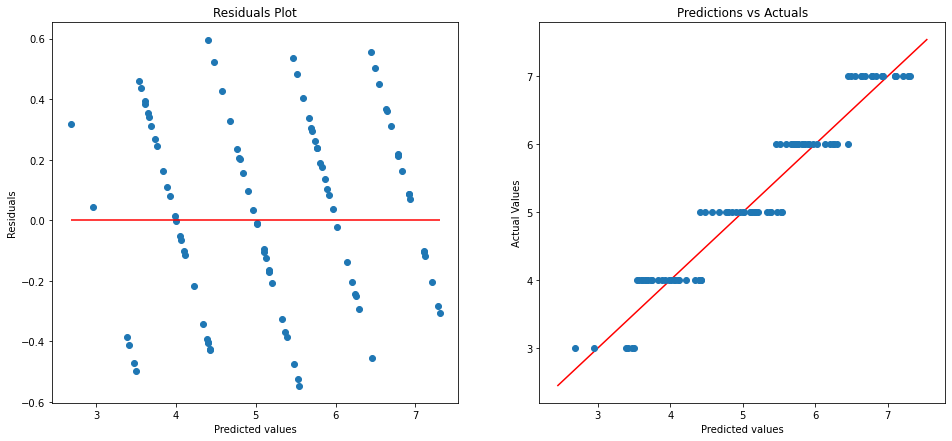

In [20]:
# plot residuals and prediction vs actual
plot_pred(lm, X_test_sc, y_test)

In [21]:
# add model for comparison
add_model('LinReg Default', lm, X_test_sc, y_test)

,RMSE,R2 Score
Baseline,1.218701,-0.017812
LinReg Default,0.353228,0.937146


# Ridge Regression with hyperparameter tuning

In [22]:
# choose values of alpha to train
r_alphas = np.logspace(0.01, 10, 500)

# instantiate ridgeCV
ridge_cv = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)

# fit ridgeCV to train data
ridge_cv = ridge_cv.fit(X_train_sc, y_train)

In [23]:
# store best value for alpha
ridge_a = ridge_cv.alpha_

In [24]:
#instantiate ridge with best value for alpha
ridge_tuned = Ridge(alpha = ridge_a )

#fit ridge to train data
ridge_tuned.fit(X_train_sc, y_train)

Ridge(alpha=2.3461767214368203)

In [25]:
# compare train, test, cv scores
display_r2(ridge_tuned, X_train_sc, y_train, X_test_sc, y_test)

Train Score:  0.9428057
Test Score:  0.9365986
Cross Val Score: 0.9082021


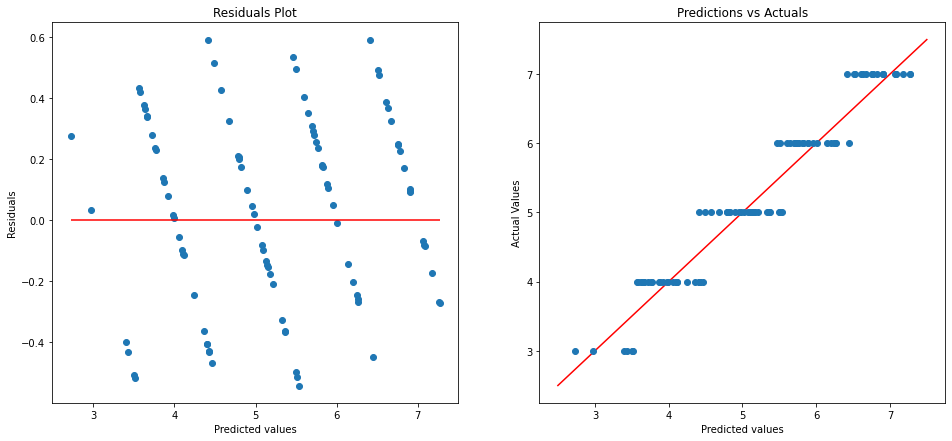

In [26]:
# plot residuals and prediction vs actual
plot_pred(ridge_tuned, X_test_sc, y_test)

In [27]:
# add model for comparison
add_model('Ridge with Hyperparameter Tuning', ridge_tuned, X_test_sc, y_test)

,RMSE,R2 Score
Baseline,1.218701,-0.017812
LinReg Default,0.353228,0.937146
Ridge with Hyperparameter Tuning,0.352371,0.936599


# Lasso Regression with hyperparameter tuning

In [28]:
# choose values of alpha to train
l_alphas = np.logspace(-3, 100, 500)

# instantiate lassoCV
lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=80000)

# fit lassoCV to train data
lasso_cv.fit(X_train_sc, y_train);


In [29]:
# store best value for alpha
lasso_a = lasso_cv.alpha_

In [30]:
# instantiate lasso with new alpha
lasso_tuned = Lasso(alpha = lasso_a )

# fit lasso to train data
lasso_tuned.fit(X_train_sc, y_train)

Lasso(alpha=0.017317171337233546)

In [31]:
# compare train, test, cv scores

display_r2(lasso_tuned, X_train_sc, y_train, X_test_sc, y_test)

Train Score:  0.9403191
Test Score:  0.9365786
Cross Val Score: 0.9212704


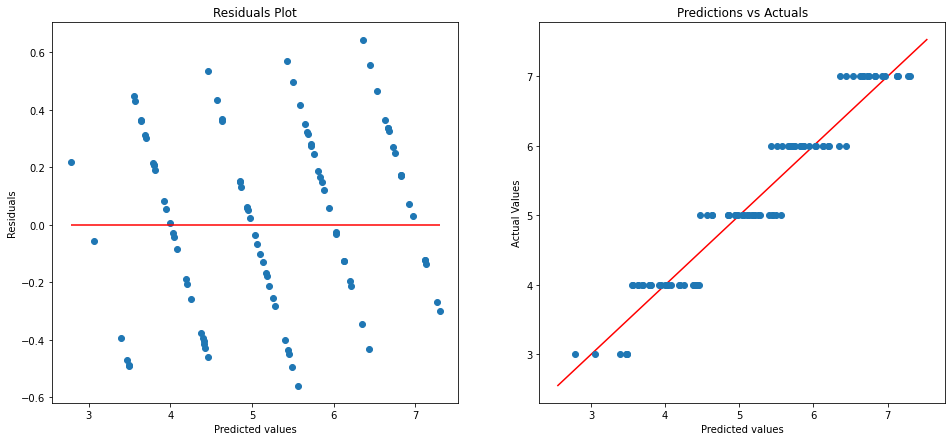

In [32]:
# plot residuals and prediction vs actual

plot_pred(lasso_tuned, X_test_sc, y_test)

In [33]:
# add model for comparison

add_model('Lasso with Hyperparameter Tuning', lasso_tuned, X_test_sc, y_test)

,RMSE,R2 Score
Baseline,1.218701,-0.017812
LinReg Default,0.353228,0.937146
Ridge with Hyperparameter Tuning,0.352371,0.936599
Lasso with Hyperparameter Tuning,0.323212,0.936579
